# Annotate Mitosis Events
can be applied to other cell events  
Author: Ke



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models
from cellpose.io import imread
import glob
from pathlib import Path
from PIL import Image, ImageSequence
from tqdm import tqdm
import os
import os.path
# from livecell_tracker import segment
from livecell_tracker import core
from livecell_tracker.core import datasets
from livecell_tracker.core.datasets import LiveCellImageDataset, SingleImageDataset
from skimage import measure
from livecell_tracker.core import SingleCellTrajectory, SingleCellStatic
# import detectron2
# from detectron2.utils.logger import setup_logger

# setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import cv2

# import some common detectron2 utilities
# from detectron2 import model_zoo
# from detectron2.engine import DefaultPredictor
# from detectron2.config import get_cfg
# from detectron2.utils.visualizer import Visualizer
# from detectron2.data import MetadataCatalog, DatasetCatalog
# from livecell_tracker.segment.detectron_utils import gen_cfg

# from livecell_tracker.segment.detectron_utils import (
#     segment_detectron_wrapper,
#     segment_images_by_detectron,
#     convert_detectron_instance_pred_masks_to_binary_masks,
#     convert_detectron_instances_to_label_masks,
# )
# from livecell_tracker.segment.detectron_utils import (
#     convert_detectron_instance_pred_masks_to_binary_masks,
#     convert_detectron_instances_to_label_masks,
#     segment_images_by_detectron,
#     segment_single_img_by_detectron_wrapper,
# )


## Loading single cells from existing mask files

```LiveCellImageDataset, SingleCellImageDataset``` from livecell_tracker.core.datasets allow users to load images with ease, without reading directly into memories.  
In `mask_dataset_path` please make sure that the sorted (alphabetically) file names correspond to the order of times.
 Note that the sorted mechanism provided is simply sort the url (file name) list according to string value. Please note that without proper left trailing zeroes, the order of final times may be incorrect. E.g. string  `T10` (10th file) is less than string `T2`. If you have your customized file patterns, please provide `LiveCellImageDataset` with a `time2url` dictionary to provide necessary time information mapped to file locations for reading time-lapsed data.
`SingleCellImageDataset` takes a single image from the memory and makes it a single time point dataset, which can be handy when you would like to process imaging datasets. 

In [2]:
# dataset_dir_path = Path(
#     "../datasets/test_data_STAV-A549/DIC_data"
# )

# mask_dataset_path = Path("../datasets/test_data_STAV-A549/mask_data")

# dataset_dir_path = Path(
#     "../datasets/EBSS_Starvation/tif_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21/XY16/"
# )

# mask_dataset_path = Path("../datasets/EBSS_Starvation/tif_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21/out/XY16/seg")
raw_image_dir_path = Path(
    "../datasets/tutorial_data_EBSS_mitosis/raw_images"
)

mask_dataset_path = Path("../datasets/tutorial_data_EBSS_mitosis/label_masks")


In [3]:
mask_dataset = LiveCellImageDataset(mask_dataset_path, ext="png")
len(mask_dataset)

39 png img file paths loaded;


39

In [4]:
time2url = sorted(glob.glob(str((Path(raw_image_dir_path) / Path("*_DIC.tif")))))
time2url = {i: path for i, path in enumerate(time2url)}
dic_dataset = LiveCellImageDataset(time2url=time2url, ext="tif")
# dic_dataset = LiveCellImageDataset(dataset_dir_path, ext="tif")

In [5]:
len(dic_dataset)

39

### Convert label masks to single objects

In [6]:
from skimage.measure import regionprops
from livecell_tracker.segment.utils import prep_scs_from_mask_dataset
single_cells = prep_scs_from_mask_dataset(mask_dataset, dic_dataset)

100%|██████████| 39/39 [00:21<00:00,  1.83it/s]


In [7]:
single_cells_by_time = {}
for cell in single_cells:
    if cell.timeframe not in single_cells_by_time:
        single_cells_by_time[cell.timeframe] = []
    single_cells_by_time[cell.timeframe].append(cell)

In [8]:
for time in single_cells_by_time:
    print(time, len(single_cells_by_time[time]))

1 14
3 18
6 22
9 18
11 22
4 23
2 22
5 20
7 21
16 15
13 20
0 20
17 17
18 16
19 16
10 22
22 20
24 18
12 19
20 16
21 18
15 17
26 20
25 21
23 17
28 23
14 20
29 18
8 19
30 20
27 19
32 18
34 19
31 18
35 17
37 17
38 17
33 18
36 17


In [9]:
from livecell_tracker.preprocess.correct_bg import correct_background_bisplrep, correct_background_median_gamma
from livecell_tracker.preprocess.utils import normalize_img_to_uint8
import numpy as np
import scipy
import scipy.interpolate as interp
from skimage import exposure, filters, morphology

sc = single_cells[0].copy()

padding_size = 30
# sc.show(crop=True)
sc_img = sc.get_img_crop(padding=padding_size)
original_sc = sc_img

bisplrep_sc_img = normalize_img_to_uint8(sc_img)
bisplrep_sc_img = correct_background_bisplrep(sc_img, sample_step=5, s=1e20)

gamma_sc_img = sc.get_img_crop(padding=padding_size)
gamma_sc_img = normalize_img_to_uint8(sc_img)
gamma_sc_img = correct_background_median_gamma(sc_img, disk_size=2)

D:\LiveCellTracker-dev\livecell_tracker\preprocess\correct_bg.py:20: FutureWarning: `selem` is a deprecated argument name for `median`. It will be removed in version 1.0. Please use `footprint` instead.
  image_median = filters.rank.median(image, selem=selem)
c:\Users\dummy\anaconda3\envs\livecell-work\lib\site-packages\skimage\filters\rank\generic.py:262: UserWarning: Bad rank filter performance is expected due to a large number of bins (26172), equivalent to an approximate bitdepth of 14.7.
  image, footprint, out, mask, n_bins = _preprocess_input(image, footprint,


In [10]:
sc1 = single_cells[1]
sc2 = single_cells[2]

## Tracking based on single cells

In [11]:
from typing import List
from livecell_tracker.track.sort_tracker_utils import (
    gen_SORT_detections_input_from_contours,
    update_traj_collection_by_SORT_tracker_detection,
    track_SORT_bbox_from_contours,
    track_SORT_bbox_from_scs
)


traj_collection = track_SORT_bbox_from_scs(single_cells, dic_dataset, mask_dataset=mask_dataset, max_age=1, min_hits=1)

matching image path: ../datasets/tutorial_data_EBSS_mitosis/raw_images/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T080_XY16_DIC.tif
matching image path: ../datasets/tutorial_data_EBSS_mitosis/raw_images/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T081_XY16_DIC.tif
matching image path: ../datasets/tutorial_data_EBSS_mitosis/raw_images/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T082_XY16_DIC.tif
matching image path: ../datasets/tutorial_data_EBSS_mitosis/raw_images/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T083_XY16_DIC.tif
matching image path: ../datasets/tutorial_data_EBSS_mitosis/raw_images/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T084_XY16_DIC.tif
matching image path: ../datasets/tutorial_data_EBSS_mitosis/raw_images/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T085_XY16_DIC.tif
matching image path: ../datasets/tutorial_data_EBSS_mitosis/raw_images/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T086_XY16_DIC.tif
matching imag

generate movies

In [12]:
# from livecell_tracker.track.movie import generate_single_trajectory_movie

# for track_id, traj in traj_collection:
#     generate_single_trajectory_movie(traj, save_path=f"./notebook_results/general_tutorial/track_movies/track_{track_id}.gif")

<Axes: ylabel='Count'>

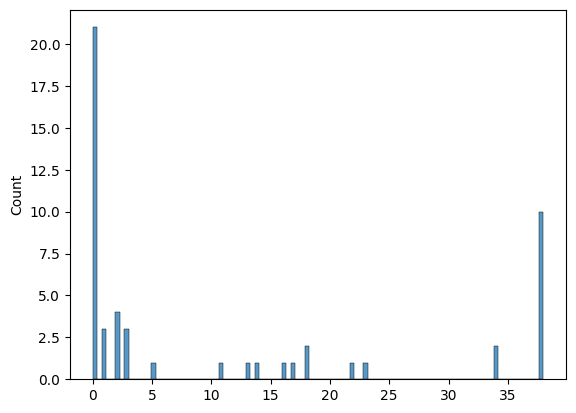

In [13]:
traj_collection.histogram_traj_length()

In [14]:
# for track_id, traj in traj_collection:
#     print("track_id=", track_id)
#     traj.timeframe_to_single_cell[list(traj.timeframe_to_single_cell.keys())[0]].show_panel(figsize=(20, 5))
#     plt.show()
    

In [15]:
%gui qt
from livecell_tracker.core.napari_visualizer import NapariVisualizer
import napari
from skimage import data


In [16]:
from livecell_tracker.core.single_cell import SingleCellStatic, SingleCellTrajectory, SingleCellTrajectoryCollection
import numpy as np
from napari.viewer import Viewer
from livecell_tracker.core.visualizer import Visualizer

from livecell_tracker.core.single_cell import SingleCellStatic, SingleCellTrajectory, SingleCellTrajectoryCollection
import numpy as np
from napari.viewer import Viewer
from livecell_tracker.core.visualizer import Visualizer


# viewer = napari.view_image(dic_dataset.to_dask(), name='dic_image', cache=True)
# shape_layer = NapariVisualizer.viz_trajectories(traj_collection, viewer, contour_sample_num=20)

### Manually or programmatically correct trajectories via SCTOperator

In [17]:
import copy
from functools import partial
from typing import Optional
from magicgui import magicgui
from magicgui.widgets import Container, PushButton, Widget, create_widget
from napari.layers import Shapes
from livecell_tracker.core.single_cell import SingleCellTrajectoryCollection


class SctOperator:
    CONNECT_MODE = 0
    DISCONNECT_MODE = 1
    ADD_MOTHER_DAUGHER_MODE = 2
    DELETE_TRAJECTORY_MODE = 3
    ANNOTATE_CLICK_MODE = 4

    def __init__(
        self,
        traj_collection: SingleCellTrajectoryCollection,
        shape_layer: Shapes,
        viewer,
        operator="connect",
        magicgui_container=None,
    ):
        self.select_info = []  # [cur_sct, cur_sc, selected_shape_index]
        self.operator = operator
        self.shape_layer: Optional[Shapes] = shape_layer
        self.setup_shape_layer(shape_layer)
        self.traj_collection = traj_collection
        self.viewer = viewer
        self.magicgui_container = magicgui_container
        self.mode = SctOperator.CONNECT_MODE
        self.annotate_click_samples = []

    def select_shape(self, event, shape_layer=None):
        if shape_layer is None:
            shape_layer = self.shape_layer
        print("current shape layer shape properties: ", event)
        current_properties = shape_layer.current_properties
        assert len(current_properties["sc"]) == 1 and len(current_properties["track_id"]) == 1
        if len(shape_layer.selected_data) > 1:
            print("Please select only one shape at a time for connecting trajectories")
            return
        if len(shape_layer.selected_data) == 0:
            print("No shape selected, please select a shape to connect trajectories")
            return
        selected_shape_index = list(shape_layer.selected_data)[0]

        shape_indices_in_select_info = set([info[2] for info in self.select_info])
        if selected_shape_index in shape_indices_in_select_info:
            print("shape already selected, please select another shape")
            return

        cur_sc = current_properties["sc"][0]
        cur_track_id = current_properties["track_id"][0]
        cur_sct = self.traj_collection[cur_track_id]

        print("setting face color of selected shape...")
        if self.mode == self.CONNECT_MODE:
            selection_face_color = (1, 0, 0, 1)
            selection_status_text = "connect"
        elif self.mode == self.DISCONNECT_MODE:
            selection_face_color = (0, 1, 0, 1)
            selection_status_text = "disconnect"
        elif self.mode == self.ADD_MOTHER_DAUGHER_MODE:
            print("len of select_info", len(self.select_info))
            if len(self.select_info) == 0:
                selection_face_color = (1, 0, 0, 1)
                selection_status_text = "mother"
            else:
                selection_face_color = (0, 0, 1, 1)
                selection_status_text = "daughter"
        elif self.mode == self.DELETE_TRAJECTORY_MODE:
            selection_face_color = (0, 0, 0, 1)
            selection_status_text = "delete?"
        elif self.mode == self.ANNOTATE_CLICK_MODE:
            selection_face_color = (102/255, 179/255, 1, 1)
            selection_status_text = "selected"

        face_colors = list(shape_layer.face_color)
        face_colors[selected_shape_index] = selection_face_color
        shape_layer.face_color = face_colors

        properties = shape_layer.properties.copy()
        properties["status"][selected_shape_index] = selection_status_text
        shape_layer.properties = properties
        shape = shape_layer.data[selected_shape_index]
        # slice_index = viewer.dims.current_step[0]
        self.select_info.append((cur_sct, cur_sc, selected_shape_index))
        print("<selection complete>")
        return cur_sct, cur_sc, selected_shape_index

    def update_shape_layer(self, shape_index, track_id, sc, face_color):
        properties = self.shape_layer.properties
        properties["track_id"][shape_index] = track_id
        properties["sc"][shape_index] = sc
        properties["status"][shape_index] = ""
        self.shape_layer.properties = properties
        face_colors = list(self.shape_layer.face_color)
        face_colors[shape_index] = face_color
        self.shape_layer.face_color = face_colors

    def update_shape_layer_by_track_id(self, track_id, face_color, new_track_id):
        properties = self.shape_layer.properties.copy()
        face_colors = list(self.shape_layer.face_color)
        new_track_ids = properties["track_id"].copy()
        for shape_index in range(len(self.shape_layer.properties["track_id"])):
            if properties["track_id"][shape_index] == track_id:
                sc = properties["sc"][shape_index]
                new_track_ids[shape_index] = new_track_id
                face_colors[shape_index] = face_color
        properties["track_id"] = new_track_ids
        self.shape_layer.properties = properties
        self.shape_layer.face_color = face_colors
        print("<update track_id properties complete>")

    def connect_two_scts(self):
        assert len(self.select_info) == 2, "Please select two shapes to connect."
        sct1, sc1, shape_index1 = self.select_info[0]
        sct2, sc2, shape_index2 = self.select_info[1]
        if sct1 == sct2:
            print("Skipping connecting two shapes from the same trajectory...")
            return
        print("connecting two shapes from different trajectories...")
        sct1_span = sct1.get_timeframe_span()
        sct2_span = sct2.get_timeframe_span()

        if sct1_span[1] < sct2_span[0] or sct2_span[1] < sct1_span[0]:
            res_traj = sct1.copy()
            res_traj.add_nonoverlapping_sct(sct2)
            self.traj_collection.pop_trajectory(sct1.track_id)
            self.traj_collection.pop_trajectory(sct2.track_id)
            self.traj_collection.add_trajectory(res_traj)

            # self.viewer.layers.remove(self.shape_layer)
            # self.shape_layer = NapariVisualizer.viz_trajectories(self.traj_collection, self.viewer, contour_sample_num=20)
            # self.setup_shape_layer(self.shape_layer)
            new_face_color = self.original_face_colors[shape_index1]
            self.clear_selection()
            self.update_shape_layer_by_track_id(
                sct1.track_id, face_color=new_face_color, new_track_id=res_traj.track_id
            )
            self.update_shape_layer_by_track_id(
                sct2.track_id, face_color=new_face_color, new_track_id=res_traj.track_id
            )
            self.store_shape_layer_info()

        else:
            raise NotImplementedError("Two trajectories are overlapping, notImplemented for now...")
        print("connect operation complete!")

    def clear_selection(self):
        print("clearing selection...")
        self.select_info = []
        self.shape_layer.face_color = list(self.original_face_colors)
        self.shape_layer.properties = self.original_properties
        print("<clear complete>")

    def setup_shape_layer(self, shape_layer: Shapes):
        self.shape_layer = shape_layer
        shape_layer.events.current_properties.connect(self.select_shape)
        self.store_shape_layer_info()

    def store_shape_layer_info(self):
        # w/o deepcopy, the original_face_colors will be changed when shape_layer.face_color is changed...
        self.original_face_colors = copy.deepcopy(list(self.shape_layer.face_color))
        self.original_properties = copy.deepcopy(self.shape_layer.properties.copy())

    def disconnect_sct(self):
        assert len(self.select_info) == 1, "Please select one shape to disconnect."
        sct, sc, old_shape_index = self.select_info[0]
        print("disconnecting shape...")
        old_traj = self.traj_collection.pop_trajectory(sct.track_id)
        new_sct1, new_sct2 = old_traj.split(sc.timeframe)
        self.traj_collection.add_trajectory(new_sct1)
        self.traj_collection.add_trajectory(new_sct2)

        color_1, color_2 = self.original_face_colors[old_shape_index], self.original_face_colors[old_shape_index]
        new_span_1 = new_sct1.get_timeframe_span()
        new_span_2 = new_sct2.get_timeframe_span()

        old_track_id = sct.track_id

        # obtain all shapes belonged to old trajectory
        old_track_shape_indices = []
        for i in range(len(self.shape_layer.properties["track_id"])):
            if self.shape_layer.properties["track_id"][i] == old_track_id:
                old_track_shape_indices.append(i)

        # update the shapes belonged to the new trajectory 1
        mutable_properties = self.shape_layer.properties.copy()
        mutable_face_colors = list(self.shape_layer.face_color)
        traj1_shape_indices = [idx for idx in old_track_shape_indices if idx < old_shape_index]
        for shape_index in traj1_shape_indices:
            mutable_properties["track_id"][shape_index] = new_sct1.track_id
            mutable_face_colors[shape_index] = color_1
        # update the shapes belonged to the new trajectory 1
        traj2_shape_indices = [idx for idx in old_track_shape_indices if idx >= old_shape_index]
        for shape_index in traj2_shape_indices:
            mutable_properties["track_id"][shape_index] = new_sct2.track_id
            mutable_face_colors[shape_index] = color_2

        mutable_properties["status"][old_shape_index] = ""
        self.shape_layer.properties = mutable_properties
        self.shape_layer.face_color = mutable_face_colors

        # # slow version below by removing and adding the entire shape layer
        # self.viewer.layers.remove(self.shape_layer)
        # self.shape_layer = NapariVisualizer.viz_trajectories(self.traj_collection, self.viewer, contour_sample_num=20)
        # self.setup_shape_layer(self.shape_layer)

        self.store_shape_layer_info()
        self.clear_selection()
        print("<disconnect operation complete>")

    def add_mother_daughter_relation(self):
        assert len(self.select_info) >= 2, "Please select >2 shapes to add mother daughter relation."
        mother_sct, mother_sc, mother_shape_index = self.select_info[0]
        for i in range(1, len(self.select_info)):
            daughter_sct, daughter_sc, daughter_shape_index = self.select_info[i]
            assert mother_sct != daughter_sct, "mother and daughter cannot be from the same trajectory!"
            mother_sct.add_daughter(daughter_sct)
            daughter_sct.add_mother(mother_sct)
        self.clear_selection()
        print("<add mother-daughter relation operation complete>")

    def delete_selected_sct(self):
        assert len(self.select_info) == 1, "Please select one shape to delete."
        sct, sc, shape_index = self.select_info[0]
        print("deleting shape...")
        self.shape_layer.selected_data = [shape_index]
        self.shape_layer.remove_selected()
        self.traj_collection.pop_trajectory(sct.track_id)
        self.store_shape_layer_info()
        self.clear_selection()
        print("<delete operation complete>")

    def annotate_click(self):
        print("<annotating click>: adding a sample")
        sample = []
        for selected_shape in self.select_info:
            sct, sc, shape_index = selected_shape
            sample.append(sc)
        self.annotate_click_samples.append(sample)
        self.clear_selection()
        print("<annotate click operation complete>")

    def hide_function_widgets(self):
        for i in range(2, len(self.magicgui_container)):
            self.magicgui_container[i].hide()

    def show_selected_mode_widget(self):
        if self.mode == self.CONNECT_MODE:
            self.magicgui_container[2].show()
        elif self.mode == self.DISCONNECT_MODE:
            self.magicgui_container[3].show()
        elif self.mode == self.ADD_MOTHER_DAUGHER_MODE:
            self.magicgui_container[4].show()
        elif self.mode == self.DELETE_TRAJECTORY_MODE:
            self.magicgui_container[5].show()
        elif self.mode == self.ANNOTATE_CLICK_MODE:
            self.magicgui_container[6].show()
        else:
            raise ValueError("Invalid mode!")


def create_sct_napari_ui(sct_operator: SctOperator):
    """Usage
    # viewer = napari.view_image(dic_dataset.to_dask(), name="dic_image", cache=True)
    # shape_layer = NapariVisualizer.viz_trajectories(traj_collection, viewer, contour_sample_num=20)
    # sct_operator = SctOperator(traj_collection, shape_layer, viewer)
    # sct_operator.setup_shape_layer(shape_layer)

    Parameters
    ----------
    sct_operator : SctOperator
        _description_
    """

    @magicgui(call_button="connect")
    def connect_widget():
        print("connect callback fired!")
        sct_operator.connect_two_scts()

    @magicgui(call_button="clear selection")
    def clear_selection_widget():
        print("clear selection callback fired!")
        sct_operator.clear_selection()

    @magicgui(call_button="disconnect")
    def disconnect_widget():
        print("disconnect callback fired!")
        sct_operator.disconnect_sct()

    @magicgui(call_button="add mother/daughter relation")
    def add_mother_daughter_relation_widget():
        print("add mother/daughter relation callback fired!")
        sct_operator.add_mother_daughter_relation()


    @magicgui(call_button="delete trajectory")
    def delete_trajectory_widget():
        print("delete trajectory callback fired!")
        sct_operator.delete_selected_sct()

    @magicgui(call_button="click&annotate")
    def annotate_click_widget():
        print("annotate callback fired!")
        # sct_operator.delete_selected_sct()
        sct_operator.annotate_click()

    @magicgui(
        auto_call=True, mode={"choices": ["connect", "disconnect", "add mother/daughter relation", "delete trajectory", "click&annotate"]}
    )
    def switch_mode_widget(mode):
        print("switch mode callback fired!")
        print("mode changed to", mode)
        if mode == "connect":
            sct_operator.mode = sct_operator.CONNECT_MODE
        elif mode == "disconnect":
            sct_operator.mode = sct_operator.DISCONNECT_MODE
        elif mode == "add mother/daughter relation":
            sct_operator.mode = sct_operator.ADD_MOTHER_DAUGHER_MODE
        elif mode == "delete trajectory":
            sct_operator.mode = sct_operator.DELETE_TRAJECTORY_MODE
        elif mode == "click&annotate":
            sct_operator.mode = sct_operator.ANNOTATE_CLICK_MODE
        sct_operator.hide_function_widgets()
        sct_operator.show_selected_mode_widget()
        sct_operator.clear_selection()

    container = Container(
        widgets=[
            switch_mode_widget,
            clear_selection_widget,
            connect_widget,
            disconnect_widget,
            add_mother_daughter_relation_widget,
            delete_trajectory_widget,
            annotate_click_widget,
        ],
        labels=False,
    )

    sct_operator.magicgui_container = container
    sct_operator.hide_function_widgets()
    sct_operator.show_selected_mode_widget()
    sct_operator.viewer.window.add_dock_widget(container, name="SCT Operator")


In [18]:
import napari
# from livecell_tracker.core.sct_operator import SctOperator, create_sct_napari_ui
viewer = napari.view_image(dic_dataset.to_dask(), name="dic_image", cache=True)
shape_layer = NapariVisualizer.gen_trajectories_shapes(traj_collection, viewer, contour_sample_num=20)
shape_layer.mode = "select"

sct_operator = SctOperator(traj_collection, shape_layer, viewer)
# sct_operator.setup_shape_layer(shape_layer)
create_sct_napari_ui(sct_operator)

Now please annotate some cells in the napari UI by choosing "click&annotate"

Save programmatically

In [21]:
sample_out_dir = Path("./test_sample_out")
filename_pattern = "sample_{sample_index}.json"
sample_out_dir.mkdir(exist_ok=True)
sample_dataset_dir = sample_out_dir / "datasets"
samples = sct_operator.annotate_click_samples
sample_paths = []

for i, sample in enumerate(samples):
    sample_json_path = sample_out_dir / (filename_pattern.format(sample_index=i))
    SingleCellStatic.write_single_cells_json(sample, sample_json_path, dataset_dir = sample_dataset_dir)
    sample_paths.append(sample_json_path)

### Check if samples are saved successfully

In [22]:
# Load and Check if samples are saved successfully
sample_path = sample_paths[0]
sample = SingleCellStatic.load_single_cells_json(sample_path, dataset_json_dir = sample_dataset_dir)
print(sample)

[SingleCellStatic(id=629c1f13-7bca-4488-a8b2-9cc02625aef7, timeframe=19, bbox=[1417. 1168. 1537. 1259.]), SingleCellStatic(id=7fd0baac-5fb3-4123-8793-a0b625e4825a, timeframe=19, bbox=[1335. 1283. 1483. 1548.]), SingleCellStatic(id=03c47ae8-9d3a-4e1b-b73c-faec6535bf71, timeframe=19, bbox=[1560. 1199. 1631. 1297.])]
